In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# used this tutorial to help. 
# https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert#import_libraries

import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler



import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification, TFBertModel, BertConfig

from tqdm import tqdm
# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import os

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
from textblob import Word

# import wandb


# #configs
# max_tokens = 20000
# embed_dim  = 300
# num_heads  = 2
# dense_dim  = 32


developing = True

BATCH_SIZE = 12
BUFFER_SIZE = 3200
SEQ_LEN = 1536
AUTO = tf.data.AUTOTUNE

/Users/sarahhoover/miniforge3/envs/w207_final/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#sample_submission_raw = pd.read_csv('/Users/sarahhoover/Desktop/W207/kaggle_english_language_grading/sample_submission.csv')
train_data_raw = pd.read_csv('/Users/sarahhoover/Desktop/W207/kaggle_english_language_grading/train.csv')
test_from_comp = pd.read_csv('/Users/sarahhoover/Desktop/W207/kaggle_english_language_grading/test.csv')


train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation


targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_y = train[targets]
val_y = val[targets]
test_y = test[targets]

train_x = train['full_text']
val_x = val['full_text']
test_x = test['full_text']
test_data_comp = test_from_comp['full_text']



In [3]:
tokenizer = BertTokenizer.from_pretrained('/Users/sarahhoover/Desktop/W207/kaggle_english_language_grading/bertbasecased')

def get_ids_mask(inputs):
    input_ids_part_one = []
    attention_mask_part_one = []
    
    input_ids_part_two = []
    attention_mask_part_two = []
    
    input_ids_part_three = []
    attention_mask_part_three = []
    

    for x in tqdm(inputs):
        tokens = tokenizer(x, padding="max_length", truncation=True, max_length=SEQ_LEN, return_tensors="np")
        ids = tokens["input_ids"]
        mask = tokens["attention_mask"]
        
        input_ids_part_one.append(ids[0][:512])
        attention_mask_part_one.append(mask[0][:512])
        
        input_ids_part_two.append(ids[0][512:1024])
        attention_mask_part_two.append(mask[0][512:1024])
        
        input_ids_part_three.append(ids[0][1024:1536])
        attention_mask_part_three.append(mask[0][1024:1536])
        
    input_ids_part_one = np.array(input_ids_part_one).squeeze()
    attention_mask_part_one = np.array(attention_mask_part_one).squeeze()
    
    input_ids_part_two = np.array(input_ids_part_two).squeeze()
    attention_mask_part_two = np.array(attention_mask_part_two).squeeze()
    
    input_ids_part_three = np.array(input_ids_part_three).squeeze()
    attention_mask_part_three = np.array(attention_mask_part_three).squeeze()
    
    return input_ids_part_one, attention_mask_part_one, input_ids_part_two, attention_mask_part_two, input_ids_part_three, attention_mask_part_three


train_input_ids_part_one, train_attention_mask_part_one, train_input_ids_part_two, train_attention_mask_part_two, train_input_ids_part_three, train_attention_mask_part_three = get_ids_mask(train_x)
val_input_ids_part_one, val_attention_mask_part_one, val_input_ids_part_two, val_attention_mask_part_two, val_input_ids_part_three, val_attention_mask_part_three = get_ids_mask(val_x)
test_input_ids_part_one, test_attention_mask_part_one, test_input_ids_part_two, test_attention_mask_part_two, test_input_ids_part_three, test_attention_mask_part_three = get_ids_mask(test_x)
test_data_comp_input_ids_part_one, test_data_comp_attention_mask_part_one, test_data_comp_input_ids_part_two, test_data_comp_attention_mask_part_two, test_data_comp_input_ids_part_three, test_data_comp_attention_mask_part_three = get_ids_mask(test_data_comp)



100%|██████████████████████████████████████████████| 3/3 [00:00<00:00, 243.43it/s]


In [4]:
class MeanPool(keras.layers.Layer):
    def call(self, x, mask=None):
        broad_mask = tf.cast(tf.expand_dims(mask, -1), "float32")
        x = tf.math.reduce_sum( x * broad_mask, axis=1)
        x = x / tf.math.maximum(tf.reduce_sum(broad_mask, axis=1), tf.constant([1e-9]))
        return x 


In [5]:
model = keras.models.load_model(
    "/Users/sarahhoover/Desktop/W207/kaggle_english_language_grading/bert_transfer_model.keras",                 
   custom_objects={
        "MeanPool": MeanPool

        })

In [6]:
test_predictions = model.predict(x={
            'tokens_one': test_input_ids_part_one,
            'attention_mask_one': test_attention_mask_part_one,
            
            'tokens_two': test_input_ids_part_two,
            'attention_mask_two': test_attention_mask_part_two,
            
            'tokens_three': test_input_ids_part_three,
            'attention_mask_three': test_attention_mask_part_three,
        })


test_predictions = pd.DataFrame(test_predictions)
test = test.reset_index()
test['cohesion_predicted'] = test_predictions[0]
test['syntax_predicted'] = test_predictions[1]
test['vocabulary_predicted'] = test_predictions[2]
test['phraseology_predicted'] = test_predictions[3]
test['grammar_predicted'] = test_predictions[4]
test['conventions_predicted'] = test_predictions[5]
test

2022-12-04 22:04:08.822739: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,index,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_predicted,syntax_predicted,vocabulary_predicted,phraseology_predicted,grammar_predicted,conventions_predicted
0,457,2286BCFF86EB,Generic_Name was sitting in the cafeteria list...,4.0,4.0,3.5,4.0,4.0,3.5,4.048340,4.130281,4.187365,4.127691,3.923795,4.048772
1,2863,CFD454F55693,The American jazz legend Duke Ellington was fa...,2.5,1.5,3.0,3.0,2.5,3.0,2.665304,2.528556,2.916800,2.696450,2.600939,2.407343
2,3299,E4F813D54870,"In some societies, students are expected to id...",3.5,3.0,3.0,3.0,3.0,3.0,3.558933,3.654609,3.776189,3.687513,3.698242,3.785335
3,2397,B2123357B114,"People have said ""positive attitude is the key...",3.5,3.0,3.0,3.0,2.5,2.5,3.167751,3.106399,3.251005,3.125591,3.079607,3.158029
4,3797,FAF2897C9B65,I agree with Winston Churchill that success co...,3.5,3.5,4.0,3.0,3.5,4.0,3.185337,3.064423,3.276067,3.202967,3.167386,3.086954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,672,340BCFE7E249,When elementry students have a lesson on what ...,2.5,3.0,3.5,3.0,3.5,3.5,3.019997,3.043649,3.063476,2.951304,2.788896,3.072680
779,2195,A3A5003C8AD1,Something that i would like to accomplish is r...,3.5,4.0,3.5,3.5,4.0,4.0,3.209097,3.451641,3.625768,3.502521,3.535727,3.399922
780,2876,D06EDF336392,A city council is debating for the adoption of...,3.0,3.0,2.5,2.5,2.5,3.0,3.417498,3.454386,3.652242,3.409591,3.153137,3.324554
781,2117,9EADCECA2FB8,i think that students should have cell phones ...,2.5,3.0,3.0,2.5,3.0,3.0,2.805951,2.816587,3.005169,2.840981,2.916574,2.885063


In [7]:
train_predictions = model.predict(x={
            'tokens_one': train_input_ids_part_one,
            'attention_mask_one': train_attention_mask_part_one,
            
            'tokens_two': train_input_ids_part_two,
            'attention_mask_two': train_attention_mask_part_two,
            
            'tokens_three': train_input_ids_part_three,
            'attention_mask_three': train_attention_mask_part_three,
        })


train_predictions = pd.DataFrame(train_predictions)
train = train.reset_index()
train['cohesion_predicted'] = train_predictions[0]
train['syntax_predicted'] = train_predictions[1]
train['vocabulary_predicted'] = train_predictions[2]
train['phraseology_predicted'] = train_predictions[3]
train['grammar_predicted'] = train_predictions[4]
train['conventions_predicted'] = train_predictions[5]
train

,index,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_predicted,syntax_predicted,vocabulary_predicted,phraseology_predicted,grammar_predicted,conventions_predicted
0,3047,D9AAEE4C9BCC,Do you think that influencing other is imporan...,3.5,3.5,2.5,3.0,3.0,3.0,3.126630,3.099595,3.234943,3.138219,3.252393,3.247048
1,2848,CEF302996231,"Dear Dr. Generic_Name,\n\nThank you for taking...",3.0,3.0,3.0,2.5,3.0,3.0,3.273497,3.243649,3.394735,3.190268,3.073912,3.095237
2,1138,584A4BB1E954,Should these summer projects be teacher-design...,2.5,3.0,3.0,2.5,3.0,3.0,3.098929,3.095891,3.207934,2.981960,3.162311,3.331980
3,2824,CDDCA13DB734,The determination make us to do something and ...,3.5,3.0,3.0,2.5,2.5,3.5,2.922404,2.756166,3.027654,2.744997,2.686765,2.827555
4,1298,63AB55DADABF,Do you think we should extend our school day? ...,4.0,4.0,4.0,3.5,4.5,3.5,3.473564,3.644129,3.532735,3.527890,3.352127,3.522892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,3654,F58DF8739B42,Dear Mr. Principal today I want to talk abot h...,3.0,3.0,3.5,2.5,3.0,2.0,2.773113,2.782276,3.025182,2.787717,2.612173,2.664050
2811,3034,D92BFF2AC7FD,Do you think is a good idea to change the scho...,3.5,3.5,3.0,3.0,3.0,3.0,3.263915,3.162204,3.306039,3.121872,3.236378,3.297581
2812,2978,D5C7212A31FD,20/11/2010\n\nMr. reader`s how are you?\n\nThi...,2.5,2.5,2.0,2.5,2.0,2.0,2.510582,2.506631,2.783130,2.523062,2.360958,2.328443
2813,1887,8E5E6211E4D6,Have you ever wondered how is it like being in...,3.0,3.0,3.5,3.5,3.5,3.0,3.036276,3.102162,3.282609,3.163854,3.242950,3.087075


In [8]:
val_predictions = model.predict(x={
            'tokens_one': val_input_ids_part_one,
            'attention_mask_one': val_attention_mask_part_one,
            
            'tokens_two': val_input_ids_part_two,
            'attention_mask_two': val_attention_mask_part_two,
            
            'tokens_three': val_input_ids_part_three,
            'attention_mask_three': val_attention_mask_part_three,
        })


val_predictions = pd.DataFrame(val_predictions)
val = val.reset_index()
val['cohesion_predicted'] = val_predictions[0]
val['syntax_predicted'] = val_predictions[1]
val['vocabulary_predicted'] = val_predictions[2]
val['phraseology_predicted'] = val_predictions[3]
val['grammar_predicted'] = val_predictions[4]
val['conventions_predicted'] = val_predictions[5]
val

,index,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_predicted,syntax_predicted,vocabulary_predicted,phraseology_predicted,grammar_predicted,conventions_predicted
0,2161,A1976FDEA9E2,If I would pick a enjoyable activity it would ...,2.0,2.0,2.5,2.5,2.5,2.5,3.117572,3.034153,3.198936,3.068430,3.096608,3.058256
1,1682,7FF600C1F829,There are some young teenagers that already kn...,4.0,4.0,4.0,4.5,3.5,4.0,3.721934,3.694379,3.925144,3.802422,3.540819,3.746180
2,132,0A3964629F69,"Generic_Name\n\nMy grandma, always said that b...",2.5,3.0,2.0,2.5,2.5,2.0,2.827936,2.801123,2.996988,2.743336,2.525855,2.470680
3,2347,AE370D914104,Students would benefit from being able to atte...,3.0,3.0,3.5,3.0,3.0,4.0,2.946522,2.994196,3.128991,2.919941,2.774378,2.833235
4,67,0514D25768A0,Technology has been one of the most facts popu...,3.5,3.0,2.0,3.0,2.0,3.0,3.654247,3.595323,3.774162,3.643417,3.607944,3.781149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,1323,6574B5B58A11,"Always being active, determined to become succ...",4.0,4.0,4.5,4.0,4.5,4.5,3.688985,3.818446,3.831622,3.721604,3.531675,3.698051
309,528,2855CD45984F,Thomas Jefferson wrote about to determine neve...,2.0,2.0,3.0,3.0,2.0,2.0,2.040139,2.114894,2.414689,2.138168,2.071372,2.033538
310,988,4BBB3BA80E0E,Hello my name is Generic_Name. Im grateful to ...,3.5,3.5,3.0,3.0,3.0,3.0,3.224076,3.267325,3.432831,3.327097,3.396989,3.232652
311,265,1348668DF845,Is it a good idea for students to finish high ...,3.5,3.5,3.5,4.0,3.5,3.5,3.617420,3.615838,3.732087,3.706939,3.680094,3.780436


In [27]:
# Create engineered features for subgroup analysis
for df in [test, train, val]:

    # word counts
    df['word_count'] = df['full_text'].map(lambda x:len(x.split()))

    # average word length
    df['avg_word_len'] = df['full_text'].map(lambda x: np.mean([len(w) for w in str(x).split()]))

    # sentence count
    df['sent_count'] = df['full_text'].apply(lambda x: len(sent_tokenize(x)))

    # average sentence length
    df['avg_sent_len'] = df['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))

In [28]:
# Create subgroups based on engineered features

# Define a function to create groups based on quantiles
def create_percentiles(df, feature):
    
    # determine 25, 50, and 75 percentiles for the feature
    perc_25 = df[feature].quantile(0.25)
    perc_50 = df[feature].quantile(0.5)
    perc_75 = df[feature].quantile(0.75)
    
    # create booleans to flag if an observation is at or below the percentile
    df['less_25'] = (df[feature] <= perc_25).astype(int)
    df['less_50'] = (df[feature] <= perc_50).astype(int)
    df['less_75'] = (df[feature] <= perc_75).astype(int)
    
    # Sum the booleans (this helps us determine which category the observation falls into)
    df['sum'] = df['less_25'] + df['less_50'] + df['less_75']
    
    # Assign category labels and create categorical variable
    dict = {0: '75th-100th', 1: '50th-75th', 2: '25th-50th', 3: '0th-25th%'}
    df[feature+'_subgroup'] = df['sum'].apply(lambda x: dict[x])
    
    # Drop unnecessary columns
    df = df.drop(columns = ['less_25', 'less_50', 'less_75', 'sum'])
    
    return df

# Apply the subgroups across all datasets, for all engineered features
for df in [test, train, val]:
    for feature in ['word_count', 'avg_word_len', 'sent_count', 'avg_sent_len']:
        create_percentiles(df, feature)
        

/var/folders/t1/_mnqjkcj097245k9crznvz580000gn/T/ipykernel_35966/3389878742.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subgroup['RMSE'] = subgroup.mean(axis = 1)
/var/folders/t1/_mnqjkcj097245k9crznvz580000gn/T/ipykernel_35966/3389878742.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subgroup['RMSE'] = subgroup.mean(axis = 1)
/var/folders/t1/_mnqjkcj097245k9crznvz580000gn/T/ipykernel_35966/3389878742.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subgroup['RMSE'] 

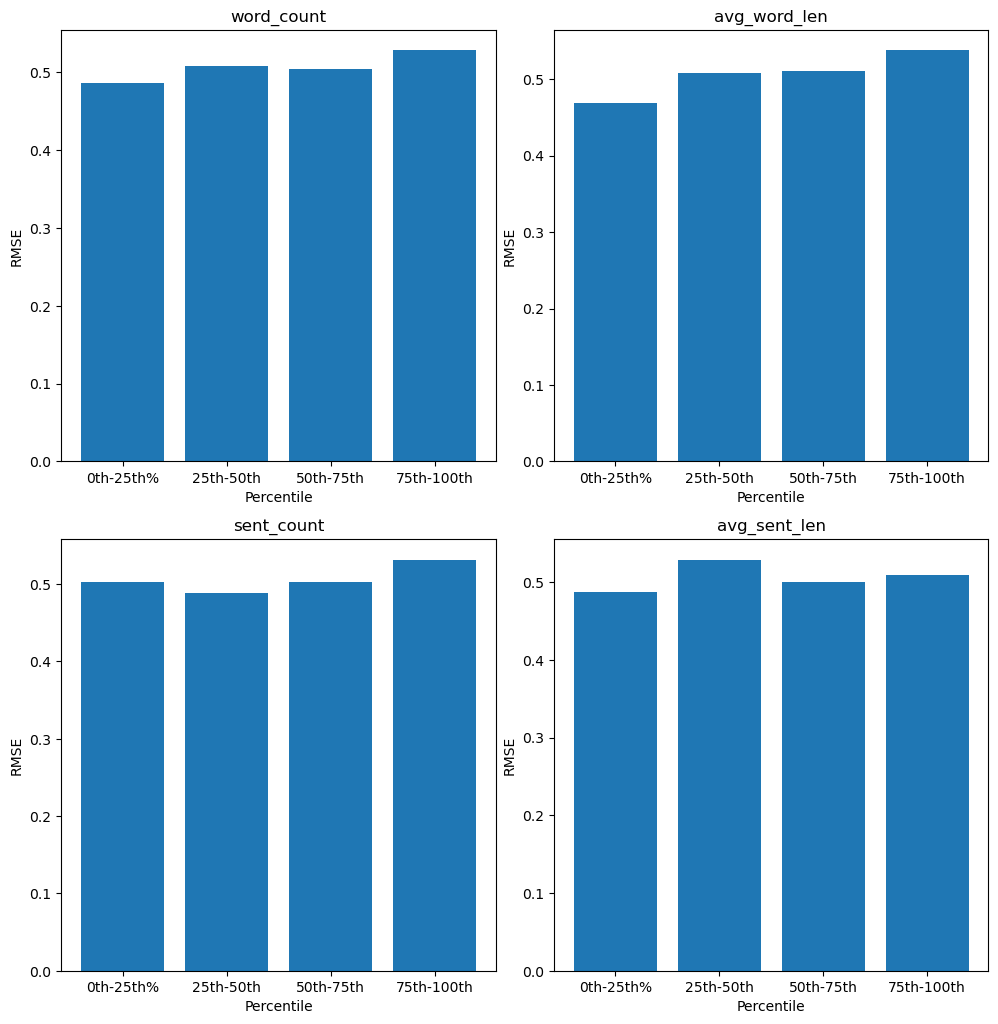

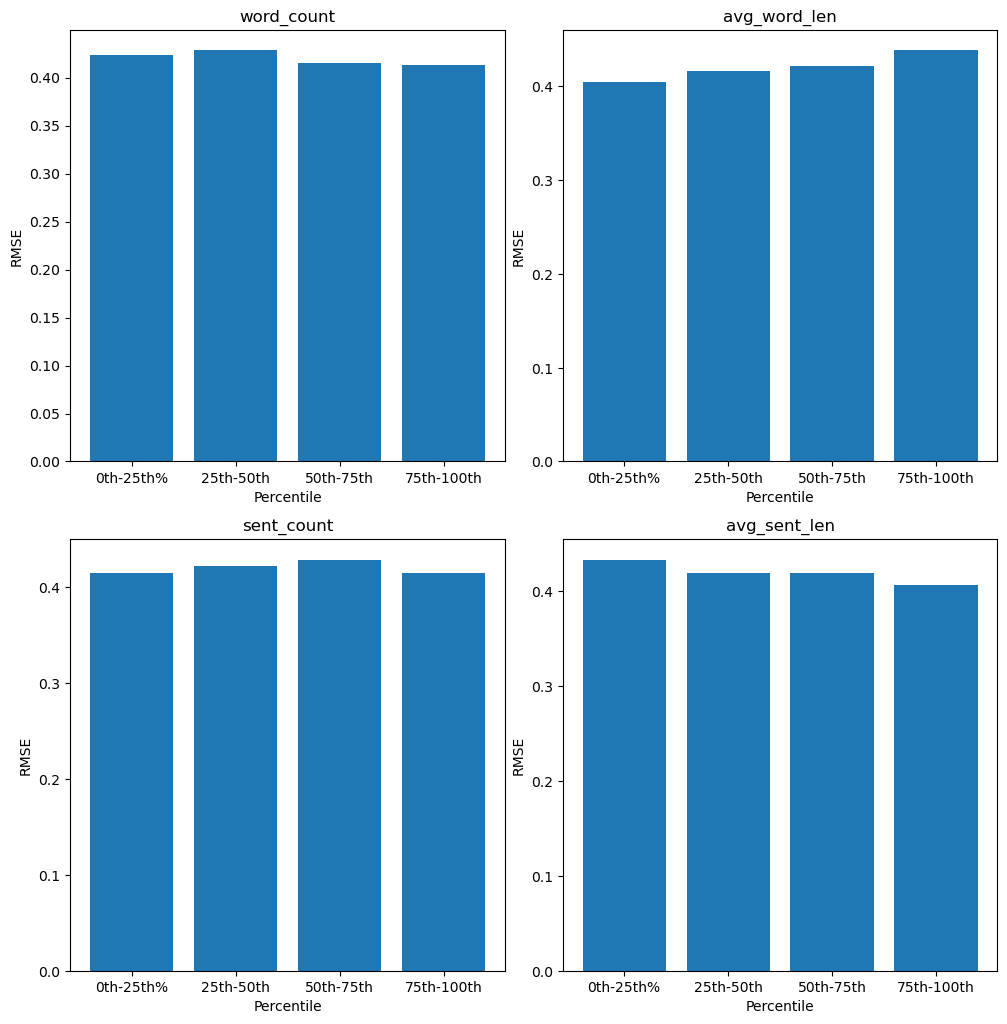

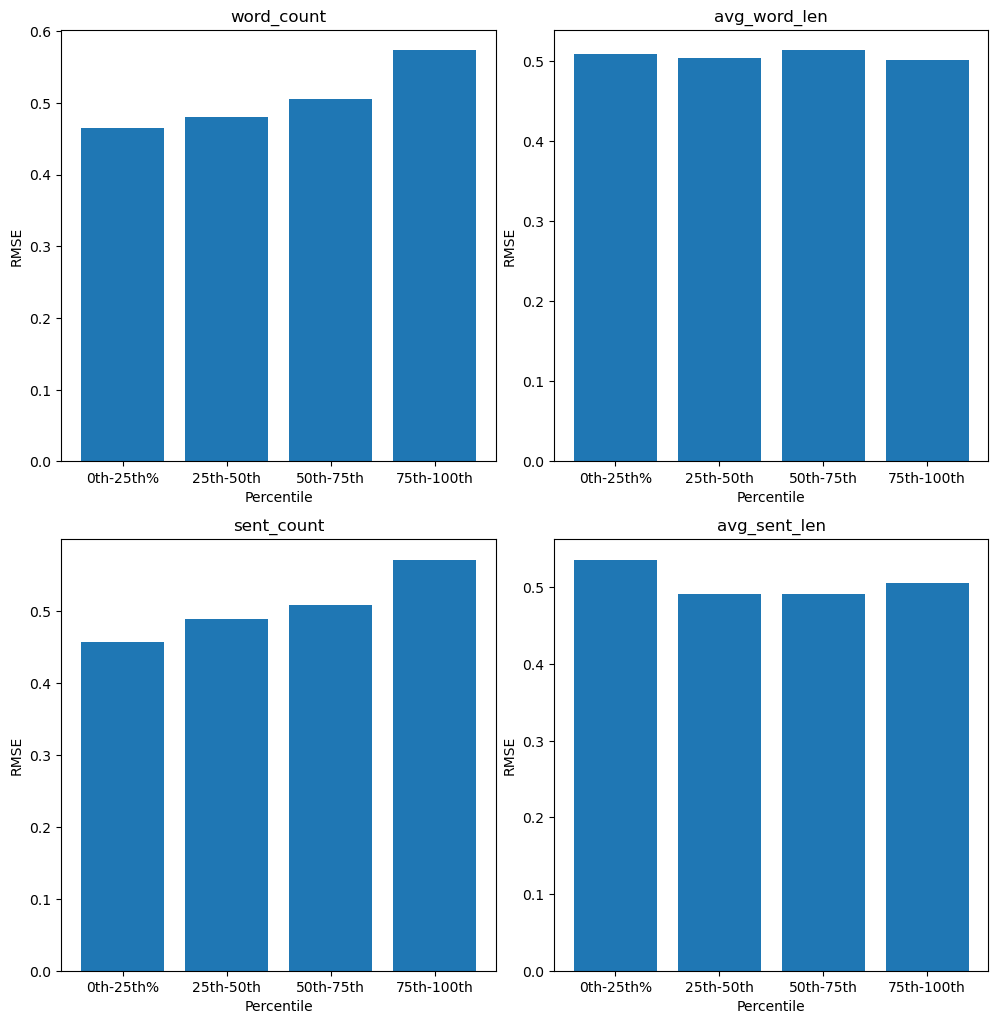

In [30]:
# Calculate RMSE across each subgroup

# Write a function to calculate the SE for a given feature
from math import sqrt
def calc_se(df, outcome):
    df[outcome + '_se'] = (df[outcome]-df[outcome+'_predicted'])**2
    return df

# Apply the SE function for each outcome in each dataset
for df in [test, train, val]:
    for outcome in ['syntax','cohesion', 'grammar', 'vocabulary', 'phraseology', 'conventions']:
        calc_se(df, outcome)

# Create a dictionary with the aggregation function to use for each SE: this is the RMSE
agg_dict = {outcome+'_se': (lambda x: sqrt(np.mean(x))) for outcome in ['syntax','cohesion', 'grammar', 'vocabulary', 'phraseology', 'conventions']}

# Calculate RMSE for each feature for each subgroup.
# Then, calculate column-wise average of the RMSEs across all outcomes. This is our primary metric we are breaking out by subgroup
for df in [test, train, val]:
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    fig.tight_layout()
    i = 1
    for feature in ['word_count', 'avg_word_len', 'sent_count', 'avg_sent_len']:
        subgroup = df.groupby(feature+'_subgroup').agg(agg_dict).reset_index()
        subgroup['RMSE'] = subgroup.mean(axis = 1)
        subgroup = subgroup[[feature+'_subgroup','RMSE']]
        plt.subplot(2, 2, i)
        plt.bar(subgroup[feature+'_subgroup'], subgroup['RMSE'])
        plt.subplots_adjust(hspace = 0.18)
        plt.title(feature)
        plt.xlabel('Percentile')
        plt.ylabel('RMSE')
        i += 1

In [31]:
# This source helped with the scatterplot code:
# https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/
test = test.assign(group = "test")
train = train.assign(group = "train")
val = val.assign(group = "validation")
full = pd.concat([train, test, val])
colors = {'train':'red', 'test':'green', 'validation':'yellow'}
        


In [32]:
full.columns

Index(['index', 'text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'cohesion_predicted',
       'syntax_predicted', 'vocabulary_predicted', 'phraseology_predicted',
       'grammar_predicted', 'conventions_predicted', 'word_count',
       'avg_word_len', 'sent_count', 'avg_sent_len', 'less_25', 'less_50',
       'less_75', 'sum', 'word_count_subgroup', 'avg_word_len_subgroup',
       'sent_count_subgroup', 'avg_sent_len_subgroup', 'cohesion_se',
       'grammar_se', 'vocabulary_se', 'phraseology_se', 'conventions_se',
       'group', 'syntax_se'],
      dtype='object')

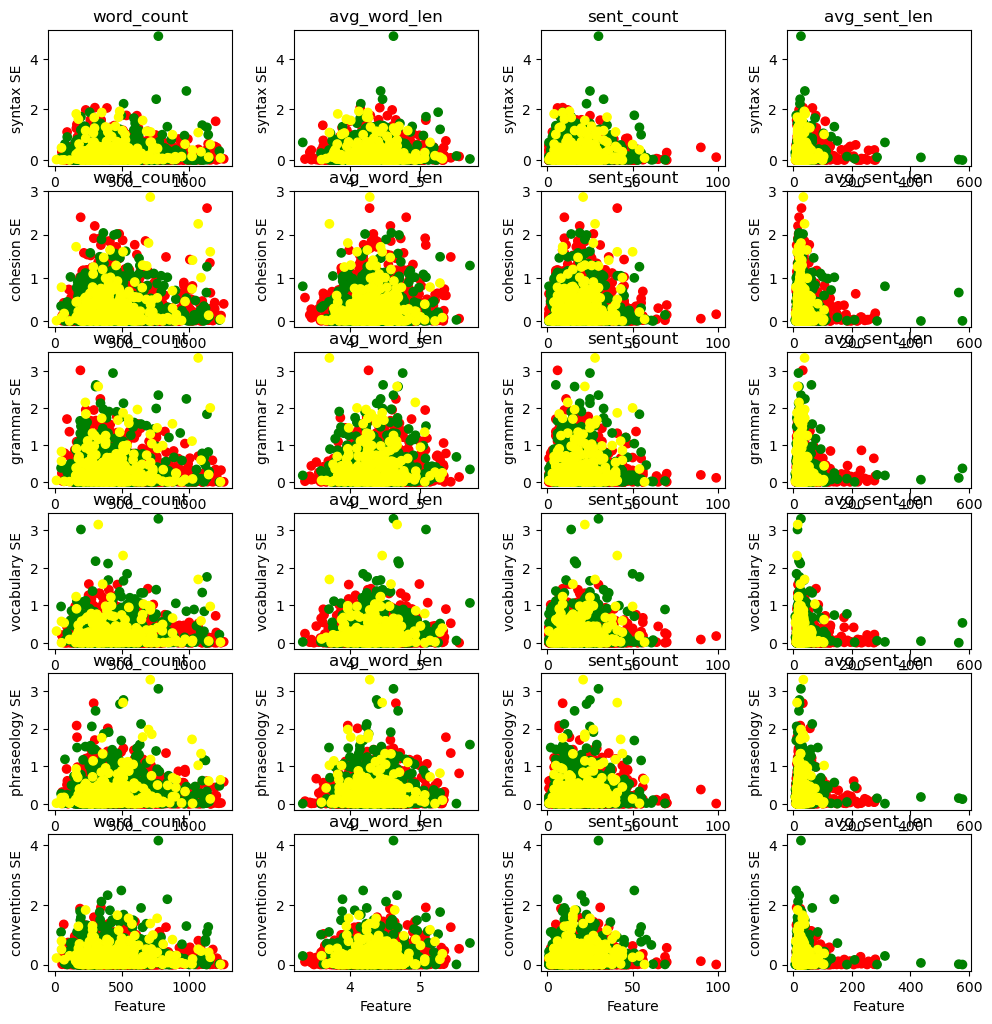

In [34]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(10,10))
fig.tight_layout()
i = 1
for outcome in ['syntax','cohesion', 'grammar', 'vocabulary', 'phraseology', 'conventions']:
    for feature in ['word_count', 'avg_word_len', 'sent_count', 'avg_sent_len']:
        plt.subplot(6, 4, i)
        plt.scatter(full[feature], full[outcome+'_se'], c=full['group'].map(colors))
        plt.subplots_adjust(hspace = 0.18)
        plt.title(feature)
        plt.xlabel('Feature')
        plt.ylabel(outcome+ ' SE')
        i += 1